In [3]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [4]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [5]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [6]:
def rsrs_beta_r2_factor(df, window_N=16):
    """
    高效计算RSRS_beta和R-squared
    """
    low = df['low']
    high = df['high']
    n = len(df)
    
    # 预分配数组
    beta = np.full(n, np.nan)
    r_squared = np.full(n, np.nan)
    
    # 预计算滚动统计量
    low_mean = low.rolling(window_N).mean()
    high_mean = high.rolling(window_N).mean()
    low_var = low.rolling(window_N).var(ddof=1)
    cov = low.rolling(window_N).cov(high)
    
    # 使用向量化计算
    for i in range(window_N-1, n):
        if low_var[i] < 1e-5:  # 避免除以零
            beta[i] = 0
            r_squared[i] = 0
            continue
            
        beta[i] = cov[i] / low_var[i]
        
        # 计算R-squared
        y = high.iloc[i-window_N+1:i+1].values
        y_pred = low.iloc[i-window_N+1:i+1].values * beta[i] + (high_mean[i] - beta[i]*low_mean[i])
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - high_mean[i])**2)
        r_squared[i] = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    beta_series = pd.Series(beta, index=df.index).ffill().fillna(0)
    r2_series = pd.Series(r_squared, index=df.index).ffill().fillna(0)
    return beta_series, r2_series

def rsrs_beta_factor(df, window_N=16):
    """使用高效版本计算基础RSRS beta"""
    beta, _ = rsrs_beta_r2_factor(df, window_N)
    return beta

def rsrs_zscore_factor(df, window_N=16, window_M=300):
    """高效计算标准分RSRS指标"""
    beta = rsrs_beta_factor(df, window_N)
    rolling_mean = beta.rolling(window_M, min_periods=1).mean()
    rolling_std = beta.rolling(window_M, min_periods=1).std().replace(0, 1e-5)
    return (beta - rolling_mean) / rolling_std

def rsrs_zscore_r2_factor(df, window_N=16, window_M=300):
    """高效计算修正标准分RSRS指标"""
    beta, r_squared = rsrs_beta_r2_factor(df, window_N)
    rolling_mean = beta.rolling(window_M, min_periods=1).mean()
    rolling_std = beta.rolling(window_M, min_periods=1).std().replace(0, 1e-5)
    return (beta - rolling_mean) / rolling_std * r_squared

def rsrs_zscore_positive_factor(df, window_N=16, window_M=300):
    """高效计算右偏标准分RSRS指标"""
    beta, r_squared = rsrs_beta_r2_factor(df, window_N)
    rolling_mean = beta.rolling(window_M, min_periods=1).mean()
    rolling_std = beta.rolling(window_M, min_periods=1).std().replace(0, 1e-5)
    return ((beta - rolling_mean) / rolling_std) * r_squared * beta

def rsrs_beta_weighted_factor(df, window_N=16):
    """高效计算加权回归的RSRS指标"""
    low = df['low']
    high = df['high']
    n = len(df)
    beta = np.full(n, np.nan)
    
    # 预计算权重
    weights = np.linspace(1, window_N, window_N)
    weights /= weights.sum()
    
    # 使用更安全的方式计算加权回归
    for i in range(window_N-1, n):
        # 获取窗口数据
        window_low = low.iloc[i-window_N+1:i+1].values
        window_high = high.iloc[i-window_N+1:i+1].values
        
        # 计算加权均值
        w_low_mean = np.dot(window_low, weights)
        w_high_mean = np.dot(window_high, weights)
        
        # 计算加权协方差和方差
        w_cov = np.dot(weights, (window_low - w_low_mean) * (window_high - w_high_mean))
        w_low_var = np.dot(weights, (window_low - w_low_mean)**2)
        
        # 计算beta
        if w_low_var < 1e-5:
            beta[i] = 0
        else:
            beta[i] = w_cov / w_low_var
    
    return pd.Series(beta, index=df.index).ffill().fillna(0)

def rsrs_zscore_blunt_factor(df, window_N=16, window_M=300, R=0.8):
    """高效计算钝化标准分RSRS指标"""
    beta = rsrs_beta_factor(df, window_N)
    rolling_mean = beta.rolling(window_M, min_periods=1).mean()
    rolling_std = beta.rolling(window_M, min_periods=1).std().replace(0, 1e-5)
    zscore = (beta - rolling_mean) / rolling_std
    
    # 计算波动率
    returns = df['close'].pct_change().fillna(0)
    vol = returns.rolling(window_N, min_periods=1).std()
    
    # 使用高效分位数计算
    vol_quantile = vol.rolling(window_M, min_periods=1).quantile(0.5)
    
    # 计算钝化因子
    blunt_factor = R ** (4 * vol_quantile)
    
    return zscore * blunt_factor

def optimize_weights(df, factors, target):
    """优化因子权重"""
    X = pd.DataFrame({name: factor(df) for name, factor in factors.items()})
    y = target(df)
    
    # 删除包含NaN的行
    valid_mask = X.notna().all(axis=1) & y.notna()
    X_valid = X[valid_mask]
    y_valid = y[valid_mask]
    
    if len(X_valid) == 0:
        return np.ones(len(factors)) / len(factors)  # 默认等权重
    
    model = LinearRegression()
    model.fit(X_valid, y_valid)
    return model.coef_

def improved_factor(df):
    """组合多个RSRS指标生成改进因子"""
    # 一次性计算基础beta和R-squared
    beta, r_squared = rsrs_beta_r2_factor(df, window_N=16)
    
    # 计算各个RSRS指标（避免重复计算）
    rsrs_zscore = rsrs_zscore_factor(df, window_N=16, window_M=300)
    rsrs_zscore_r2 = rsrs_zscore_r2_factor(df, window_N=16, window_M=300)
    rsrs_zscore_positive = rsrs_zscore_positive_factor(df, window_N=16, window_M=300)
    rsrs_beta_weighted = rsrs_beta_weighted_factor(df, window_N=16)
    rsrs_zscore_blunt = rsrs_zscore_blunt_factor(df, window_N=16, window_M=300, R=0.8)
    
    # 创建因子字典
    factors_dict = {
        'rsrs_beta': beta,
        'rsrs_zscore': rsrs_zscore,
        'rsrs_zscore_r2': rsrs_zscore_r2,
        'rsrs_zscore_positive': rsrs_zscore_positive,
        'rsrs_beta_weighted': rsrs_beta_weighted,
        'rsrs_zscore_blunt': rsrs_zscore_blunt
    }
    
    # 标准化所有因子
    standardized = {}
    for name, series in factors_dict.items():
        mean_val = series.mean()
        std_val = series.std()
        if std_val < 1e-5:
            standardized[name] = series - mean_val
        else:
            standardized[name] = (series - mean_val) / std_val
    
    # 定义因子函数
    factors = {
        name: lambda df, s=standardized[name]: s 
        for name in factors_dict.keys()
    }
    
    # 目标函数：未来10期收益率
    target = lambda df: df['close'].pct_change(10).shift(-10)
    
    # 优化权重
    try:
        weights = optimize_weights(df, factors, target)
    except Exception as e:
        print(f"权重优化失败: {e}")
        weights = np.ones(len(factors)) / len(factors)
    
    # 组合因子
    combined_factor = pd.Series(0, index=df.index)
    for name, weight in zip(factors.keys(), weights):
        combined_factor += weight * standardized[name]
    
    # 最终归一化处理
    abs_mean = combined_factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    return combined_factor / abs_mean

In [7]:
evaluator.set_factor(
    factor_data_or_func=improved_factor,
    factor_name='improved_factor_with_rsrs'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
📈 平稳性检验 (ADF):
   p_value: 0.000000
   是否平稳: 是
🔗 相关性分析:
   IC (Pearson): 0.014790
   Rank_IC (Spearman): 0.027601
📊 信息比率:
   IR: 0.402161
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130747
   因子列: improved_factor_with_rsrs
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


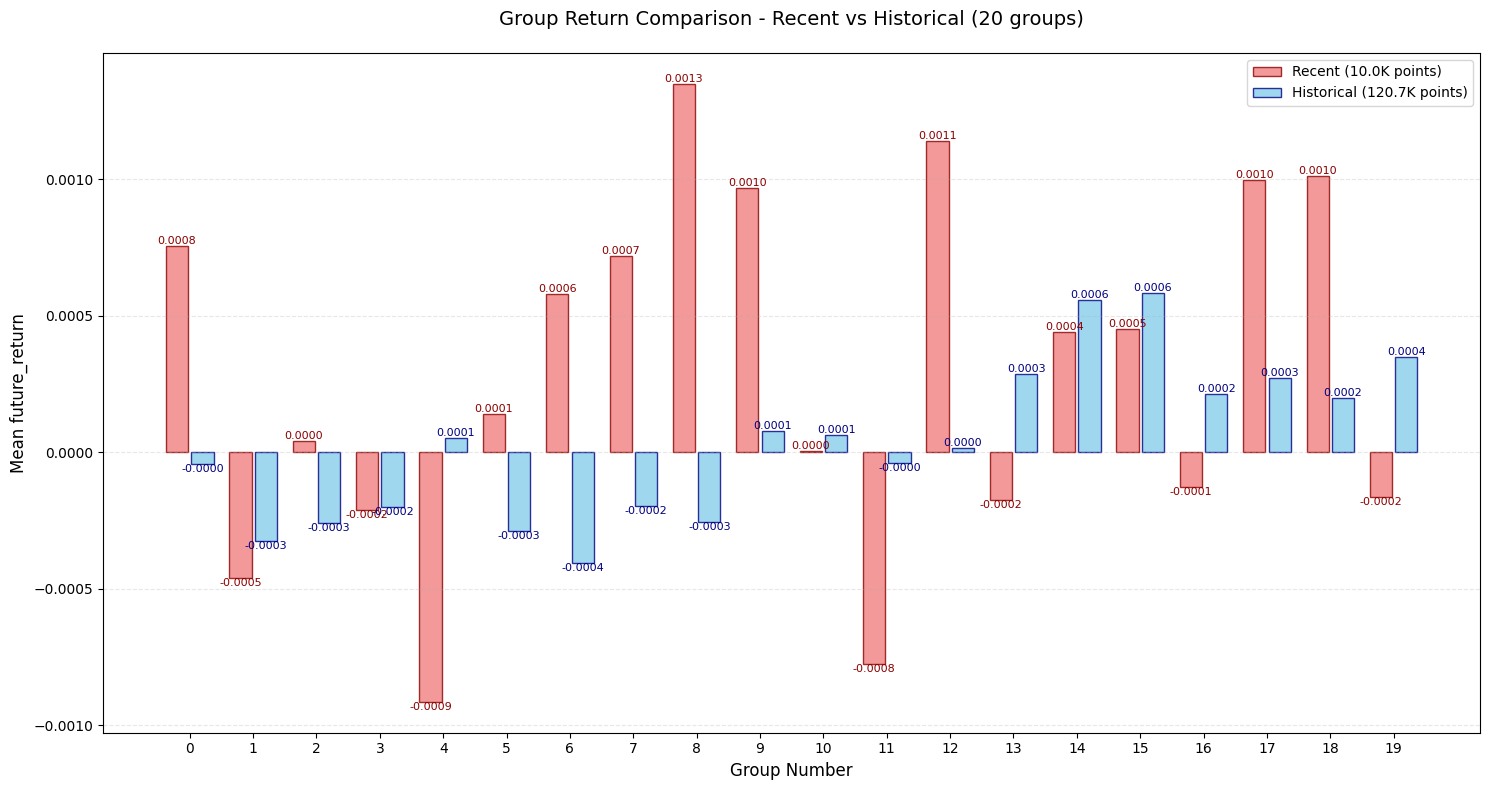

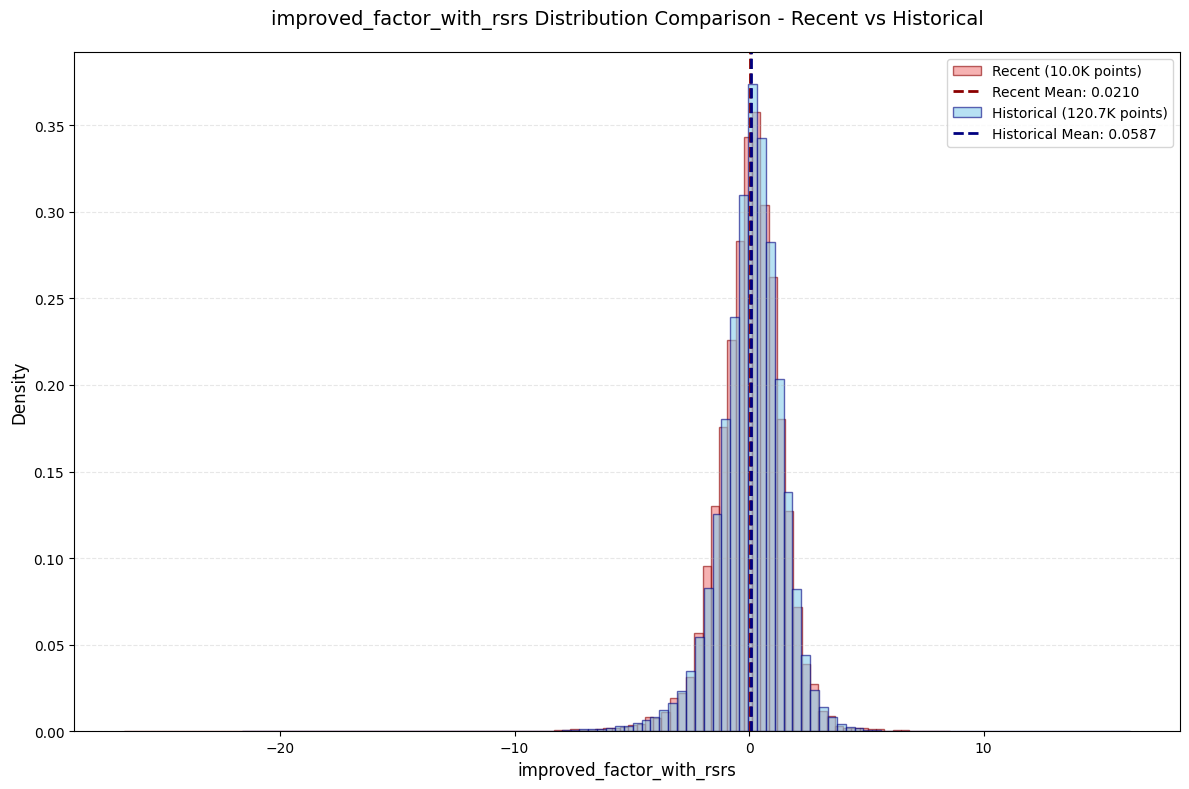

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [8]:
result=evaluator.run_full_evaluation(run_stationarity_test=True)

In [ ]:
sig=improved_factor(df)
plt.scatter(sig, result['future_return'])

NameError: name 'plt' is not defined